In [5]:
using Distributions, Plots, Random
include("../src/JS_SAA_main.jl")
pyplot()

Plots.PyPlotBackend()

In [94]:
#discrete newsvendors supported 1:d
K = 10000
s = .95
d = 10
N = 20
Random.seed!(8675309)

#gen an "interesting" distribution of ps still centered at 1/d
p0 = ones(d)/d
anchor = vcat(1., zeros(d-1))
p0 = .5 * p0 + .5 * anchor

ps = rand(Dirichlet(ones(d)), floor(Int, K/2))
qs = rand(Dirichlet(5 * ones(d)), K-floor(Int, K/2))

# qanchor = vcat(.9 * [.2, .2, .2, .2, .2], .1 * ones(d-5)/(d-5))
# qs = rand(Dirichlet(qanchor),  K - floor(Int, K/2)) 

ps = [ps qs]
alpha_grid = range(0, stop=50, length=75)
lams = ones(K)

Nhats = rand(Poisson(N), K)
mhats = JS.sim_path(ps, Nhats);

supps =  repeat(collect(1:d), outer=(1, K))
cs, xs = JS.genNewsvendorsDiffSupp(supps, s, K);

In [92]:
alpha_grid = range(0, stop=30, length=100)
outOR = map(a-> JS.zbar(xs, cs, p0, a, mhats, ps, ones(K)), alpha_grid)
outLOO = map(a->JS.zLOObar_unsc(xs, cs, p0, a, mhats), alpha_grid);
outSAA = map(a->JS.zbar(xs, cs, p0, a, mhats, mhats ./ Nhats', ones(K)), alpha_grid);
full_info = JS.zstar(xs, cs, ps, ones(K));

SAA:	4.716374746472874	0.07933072054433477
LOO:	4.484918386354869	0.026362503774121526
OR:	4.484918386354869	0.026362503774121526


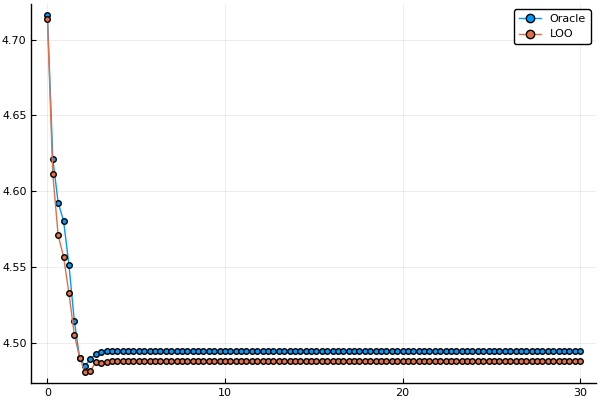

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [93]:
println("SAA:\t", outOR[1], "\t", outOR[1] / full_info - 1)
println("LOO:\t", outOR[argmin(outLOO)], "\t", outOR[argmin(outLOO)]/full_info - 1)
println("OR:\t", minimum(outOR), "\t", minimum(outOR)/full_info - 1)
plot(alpha_grid, [outOR outLOO/N], label=["Oracle" "LOO"], marker=:circ)


In [20]:
# t = ["alpha" "OR" "LOOEstim_Sc" "SAAEstim";
#     alpha_grid outOR outLOO/20 outSAA]
# writecsv("../Results/singleKAcrossAlpha_10000_.95.csv", t)

In [ ]:
### Sanity Checks.  
#  ###Check that xs(alpha) actually minimizes p(\alpha)^T c(alpha)
#  # spot check zLOO(alpha) and ZOR(alpha) against other implementation
#  # do a run for large K.
#  #check that oracle value minimized at bayesian value = 2
#  #do a curve by curve spot check
k0 = 15
alpha0 = 0
palpha_k = JS.shrink(mhats[:, k0]/Nhats[k0], p0, alpha0, Nhats[k0])
xalpha_k = xs[k0](p0, alpha0, mhats[:, k0])

println("palpha_k:\t", palpha_k)
println("x_alphak:\t", xalpha_k)

dot(palpha_k, map(c_ik -> c_ik(9), cs[:, k0])), dot(palpha_k, map(c_ik -> c_ik(10), cs[:, k0]))


# alpha = 2
# palphas = similar(ps)
# for k = 1:K
#     palphas[:, k] = JS.shrink(mhats[:, k]/Nhats[k], p0, alpha, Nhats[k])
# end

JS.zbar(xs, cs, p0, 2, mhats, ps, ones(K))

In [ ]:
### Sanity Checks.  
#  # spot check zLOO(alpha) and ZOR(alpha) against other implementation
#  # do a run for large K.
#  #check that oracle value minimized at bayesian value = 2
#  #do a curve by curve spot check

#JS.zbar(xs, cs, 1.515, mhats, ps, ones(K)) 
JS.zLOObar_unsc(xs, cs, p0, 0.44717265850424653, mhats)

In [15]:
JS.mse_estimates(mhats, collect(1:d), p0, alpha_grid)

(21, 8.080808080808081)

In [30]:
println( alpha_grid[indmin(outOR)], "\t",  alpha_grid[indmin(outLOO)] )
println(minimum(outOR), "\t", outOR[indmin(outLOO)]/minimum(outOR), "\t", outOR[21]/minimum(outOR))


20.2020202020202	15.353535353535353
4.454050472333146	1.007404080123694	1.0128793652647885


In [4]:
sum(mhats ./ Nhats', 1)

1×10000 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [ ]:
d, K = size(mhats[2:end, 2:end])

In [ ]:
sum(mhats, 1)